In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import pyro

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import scipy.stats as stats 

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
from pyro.infer import MCMC, NUTS

In [ ]:
# load the transformed dataset
business_df = pd.read_csv('../datasets/Transformed_Dataset.csv')

In [ ]:
business_df.shape

In [ ]:
print('have histograms based if it is economy class')

business_df.hist('price', bins=50, by=business_df['Economy'], sharey=True, sharex=True)

In [ ]:
# let's see histogram of all data together
business_df.hist('price', bins=70)

In [ ]:
# split the train and test, where test has class and the y has the price
train_x, test_x, train_y,test_y = train_test_split(
    business_df['Economy'].to_numpy(dtype=np.int_), 
    business_df['price'].values, 
    test_size=0.5, random_state=488)

# we need it as torch tensor
x_train_clean = torch.tensor(train_x)
y_train_clean = torch.tensor(train_y)

x_test_clean = torch.tensor(test_x)
y_test_clean = torch.tensor(test_y)

# let's get ratio of business and economy class tickets
x_train_clean.count_nonzero(), len(x_train_clean)

In [ ]:
def pyro_model(x=None, y=None):
    # priors for components
    
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([1., 1.])
    sigma_scale = torch.tensor([10., 10.])
    
    # the component is the type of class - economy/business
    with pyro.plate('components', 2): 
        mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc,mu_scale))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))
        
    with pyro.plate('data', len(y)):
        buss = x
        # index the correct distribution from which we draw
        price = pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]), obs=y)
    
    return price
    

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=200, num_chains=1)
mcmc.run(x_train_clean,y_train_clean)

# Show summary of inference results
mcmc.summary()

In [ ]:
def pyro_model(x=None, y=None):
    # priors for components
    alpha_scale = torch.tensor([3., 3.])
    beta_scale = torch.tensor([10., 10.])
    
    # component of different classes - business and economy
    with pyro.plate('components', 2):
        alpha = pyro.sample('alpha', pyro.distributions.HalfCauchy(alpha_scale))
        beta = pyro.sample('beta', pyro.distributions.HalfCauchy(beta_scale))
        
    with pyro.plate('data', len(y)):
        buss = x
        # draw from the right distribution from the mix
        price = pyro.sample('price', pyro.distributions.Gamma(alpha[buss],beta[buss]), obs=y)
    
    return price

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=200, num_chains=1)
mcmc.run(x_train_clean,y_train_clean)

# Show summary of inference results
mcmc.summary()

In [ ]:
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

In [ ]:
posterior_samples['beta'].mean(dim=0)

## first attempt:

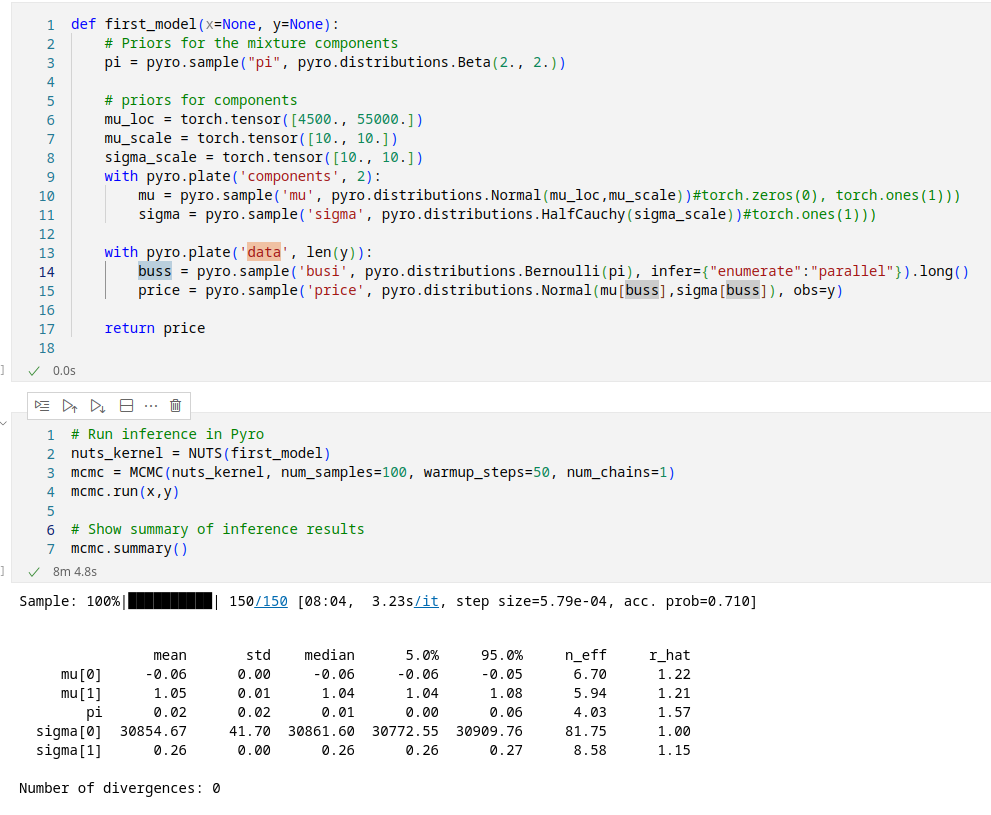

## second attempt:
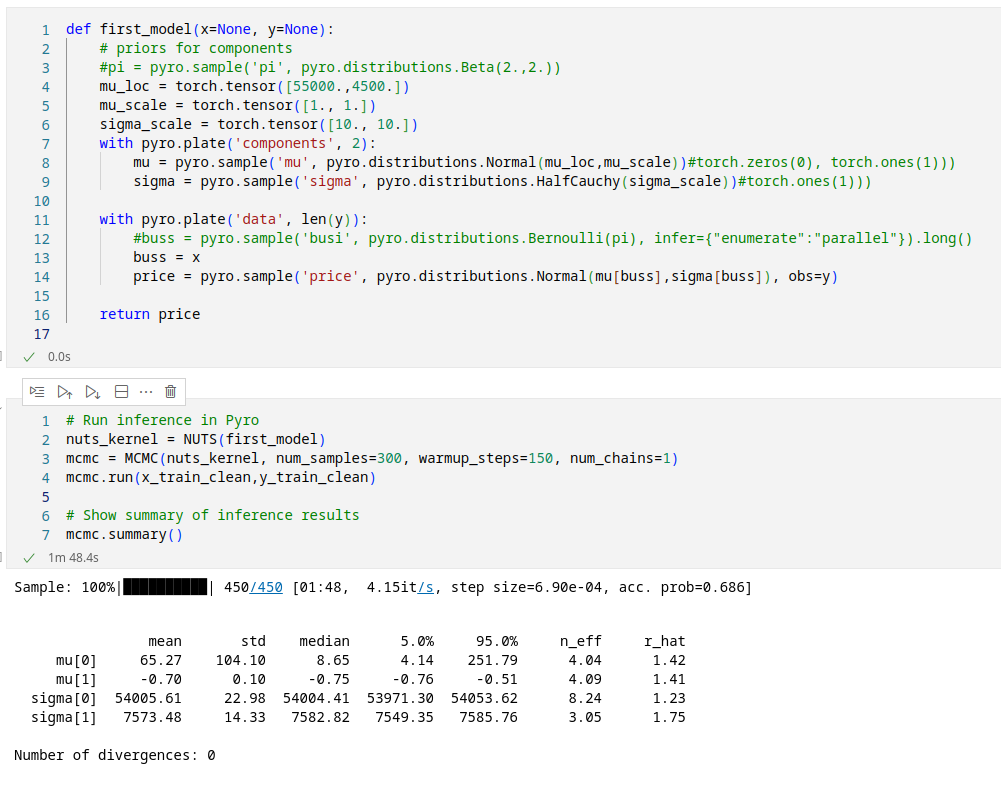

## third attempt
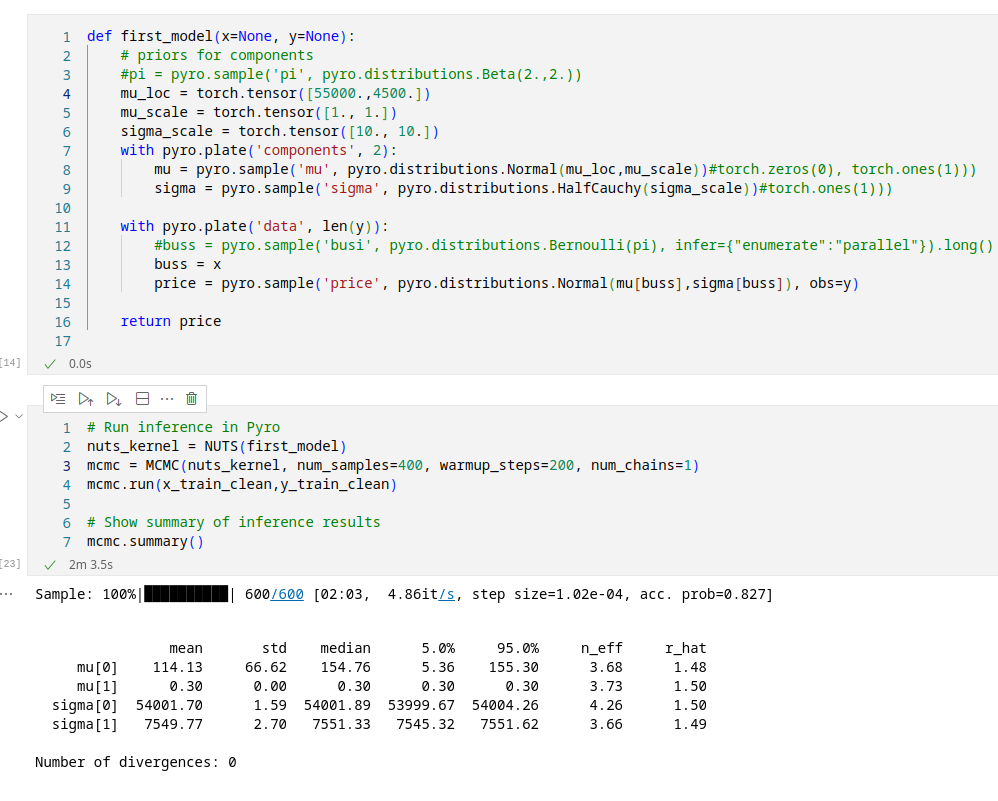

## trying out Gamma
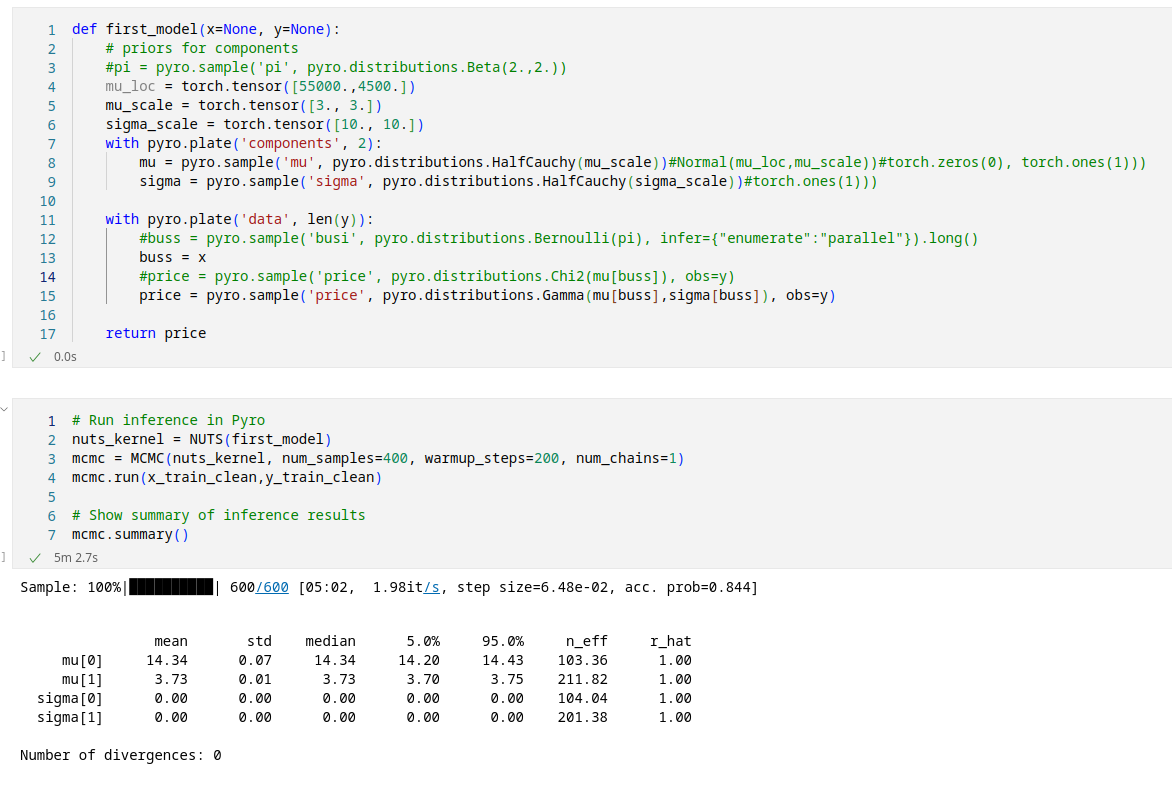

# make predictions

In [ ]:
def pyro_model(x=None, y=None):
    # priors for components
    alpha_scale = torch.tensor([3., 3.])
    beta_scale = torch.tensor([10., 10.])
    
    with pyro.plate('components', 2):
        alpha = pyro.sample('alpha', pyro.distributions.HalfCauchy(alpha_scale))
        beta = pyro.sample('beta', pyro.distributions.HalfCauchy(beta_scale))
        
    with pyro.plate('data', len(y)):
        buss = x
        
        pyro.sample('price', pyro.distributions.Gamma(alpha[buss],beta[buss]), obs=y)
        
    # make a model for predicting
    price_pred = pyro.sample('price_pred', pyro.distributions.Gamma(alpha[buss],beta[buss]))
    return price_pred

In [ ]:
def pred(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Gamma(post_samples['alpha'].mean(dim=0)[x],post_samples['beta'].mean(dim=0)[x]))

In [ ]:
posterior_samples = mcmc.get_samples()

In [ ]:
# lets see what are the values for alpha and beta
print(posterior_samples['alpha'].mean(dim=0)[1], posterior_samples['beta'].mean(dim=0)[1])
print(posterior_samples['alpha'].mean(dim=0)[0], posterior_samples['beta'].mean(dim=0)[0])

In [ ]:
# sample the ratio of business and economy so we can compare histogram from the beggining
business = pyro.distributions.Gamma(torch.tensor(14.3093), torch.tensor(0.0003)).sample_n(74938,)
economy = pyro.distributions.Gamma(torch.tensor(3.7298), torch.tensor(0.0006)).sample_n(165184,)

In [ ]:
# lets plot the mixing that we got
sns.histplot(business, bins=30, kde=True)
sns.histplot(economy, bins=30, kde=True)

plt.show()

In [ ]:
# a nice method for calculating statistics form class
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
# get predictions
pred_y = pred(x_test_clean, posterior_samples)

# get statistics about errors
corr, mae, rae, rmse, r2 = compute_error(y_test_clean.numpy(),pred_y.numpy())

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
#type(pred_y.numpy()), type(y_test_clean.numpy())

# adding the airlines into mixing

In [ ]:
# lets split the data into train and test, now the x contains class and airlines
train_x, test_x, train_y,test_y = train_test_split(
       business_df[['Economy', 'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']].to_numpy(dtype=np.int_), 
       business_df['price'].values, 
       test_size=0.2, random_state=488)

x_train_clean = torch.tensor(train_x) #business_df['Economy']
y_train_clean = torch.tensor(train_y)

x_test_clean = torch.tensor(test_x) #business_df['Economy']
y_test_clean = torch.tensor(test_y)

In [ ]:
def pyro_model(x=None, y=None):
    airline_count = 6
    # priors for components
    alpha_scale = torch.tensor([14., 4.] * airline_count).reshape(airline_count,2)
    beta_scale = torch.tensor([0.006, 0.003] * airline_count).reshape(airline_count,2)
    
    with pyro.plate('components', 2): #component of class
        with pyro.plate('airlines',airline_count): # component of airlines
            alpha = pyro.sample('alpha', pyro.distributions.HalfCauchy(alpha_scale))
            beta = pyro.sample('beta', pyro.distributions.HalfCauchy(beta_scale))
        
    with pyro.plate('data', len(y)):
        buss = x[0] # get if it is business
        airline_index = x[1] # get the index of airline
        
        # draw from the corresponding distribution parameters
        price = pyro.sample('price', pyro.distributions.Gamma(alpha[airline_index,buss],beta[airline_index,buss]), obs=y)
    
    return price

In [ ]:
# def pyro_model(x=None, y=None):
#     # priors for components
#     airline_count = 6
#     mu_scale = torch.tensor([14., 4.]) # * airline_count).reshape(airline_count,2)
#     sigma_scale = torch.tensor([0.006, 0.003] * airline_count).reshape(airline_count,2)
#     #sigma_scale = torch.tensor([0.006, 0.003])
#     with pyro.plate('components', 2):
#         with pyro.plate('airlines',airline_count):
#             sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))
#         mu = pyro.sample('mu', pyro.distributions.HalfCauchy(mu_scale))
#     with pyro.plate('data', len(y)):
#         buss = x[0] # get if it is business
#         airline_index = x[1]
#         price = pyro.sample('price', pyro.distributions.Gamma(mu[buss],sigma[airline_index,buss]), obs=y)
    
#     return price

In [ ]:
x_testing = torch.stack(
    (x_train_clean[:,0],
     torch.argmax(x_train_clean[:,1:], axis=1))) # for simple handling of airlines, we take the airlines which are in one hot encoding and transform that into indexing
x_testing

In [ ]:
# lets see what bias is there based on number of flights per airline
x_testing.unique(return_counts=True)

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, num_chains=1)
mcmc.run(x_testing,y_train_clean)

# Show summary of inference results
mcmc.summary()

In [ ]:
def pred(x, post_samples): # define how we predict data - draw from Gamma based on mean of parameters
    alpha = post_samples['alpha'].mean(dim=0)
    beta = post_samples['beta'].mean(dim=0)
    return pyro.sample('prediction', pyro.distributions.Gamma(alpha[x[1],x[0]],beta[x[1],x[0]]))

In [ ]:
posterior_samples = mcmc.get_samples()

In [ ]:
# get precise values of the betas
posterior_samples['beta'].mean(dim=0)

In [ ]:
x = np.linspace (0, 30000, 500) 

# for each of the airlines let's check how the distribution for economy class price looks like
for alpha,beta,i in zip(posterior_samples['alpha'].mean(dim=0), posterior_samples['beta'].mean(dim=0), range(6)):
    print('airline',i,'mean:', (alpha[1]/(beta[1])))
    print('alpha',alpha[1],'1/beta:', 1/(beta[1]))
    y = stats.gamma.pdf(x, a=alpha[1], scale=1/beta[1])
    plt.plot(x, y, label='airline '+str(i))

plt.legend()
plt.show()

In [ ]:
# transform test data the same way as we did for train data
x_validate = torch.stack((x_test_clean[:,0],torch.argmax(x_test_clean[:,1:], axis=1)))


In [ ]:
pred_y = pred(x_validate, posterior_samples)

corr, mae, rae, rmse, r2 = compute_error(y_test_clean.numpy(),pred_y.numpy())

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

# using mixing for airlanes as well
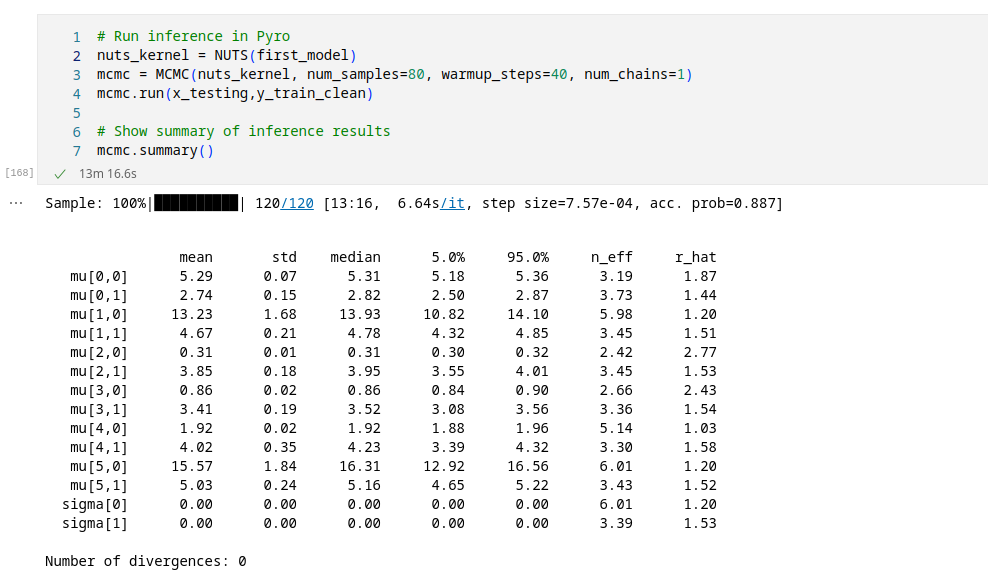

## using both parameter as latent
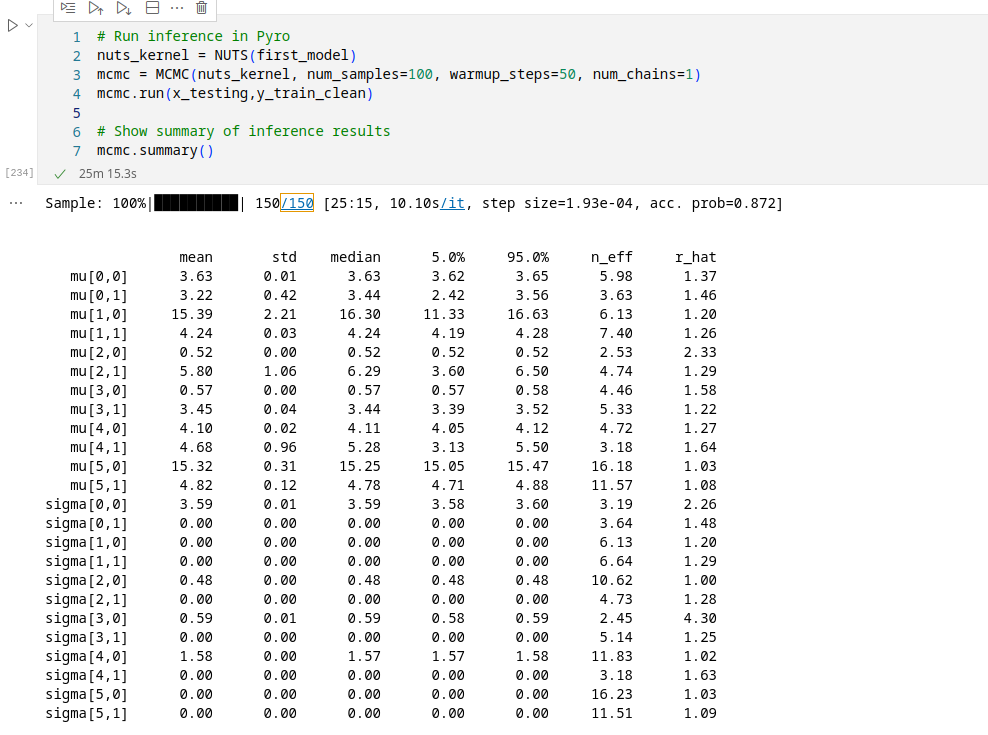


## last try
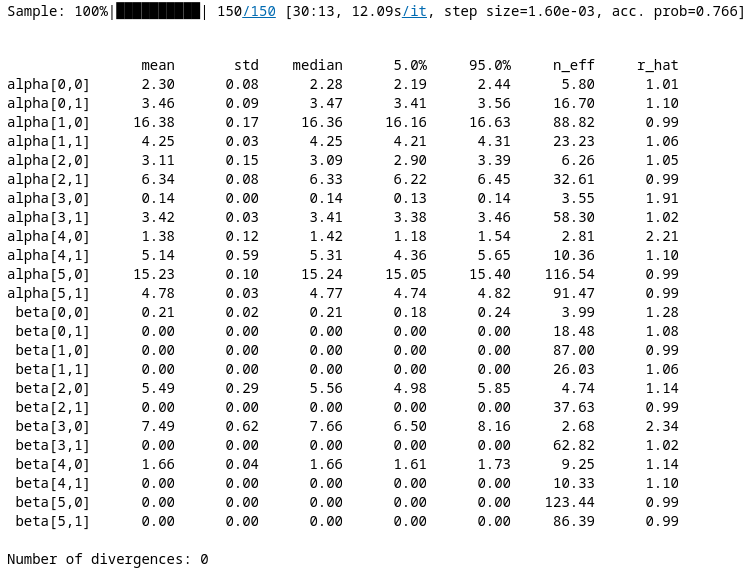

with corresponding betas:

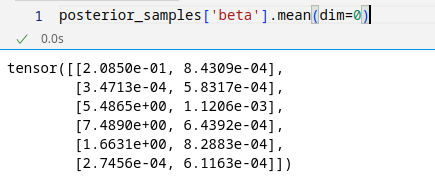

> both of them gives about 0.767 R²

# Now lets make it dependant based on time - days left until departure

In [ ]:
# lets try to make it based on the days left, so x contain class and days left
train_x, test_x, train_y,test_y = train_test_split(
    business_df[['Economy','days_left']].to_numpy(dtype=np.int_), 
    business_df['price'].values, 
    test_size=0.3, random_state=488)

x_train_clean = torch.tensor(train_x) #business_df['Economy']
y_train_clean = torch.tensor(train_y)

x_test_clean = torch.tensor(test_x) #business_df['Economy']
y_test_clean = torch.tensor(test_y)

x_train_clean.count_nonzero(), len(x_train_clean)

In [ ]:
x_train_clean, y_train_clean

In [ ]:
def pyro_model(x=None, y=None):
    # priors for days
    cutoff_days_mu = torch.zeros(2)
    cutoff_days_sigma = torch.ones(2)
    cutoff_correlaiton_mu = torch.zeros(2)
    cutoff_correlaiton_sigma = torch.ones(2)
    with pyro.plate('cut_off', 2):
        cutoff_day = pyro.sample('cut_days', pyro.distributions.Normal(cutoff_days_mu,cutoff_days_sigma))
        cutoff_correlation = pyro.sample('cut_corr', pyro.distributions.Normal(cutoff_correlaiton_mu,cutoff_correlaiton_sigma))
    
    # priors for class - business/ economy
    alpha_scale = torch.tensor([3., 3.])
    beta_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        alpha = pyro.sample('alpha', pyro.distributions.HalfCauchy(alpha_scale))
        beta = pyro.sample('beta', pyro.distributions.HalfCauchy(beta_scale))
        
    # prior for noise of final price
    price_sigma = pyro.sample('price_sigma',pyro.distributions.HalfCauchy(1))
    with pyro.plate('data', len(y)):
        
        buss = x[:,0]
        is_bought_late = torch.lt(x[:,1],cutoff_day[buss]).type(torch.int8)
        price = pyro.sample('price', pyro.distributions.Gamma(alpha[buss], beta[buss]+is_bought_late*cutoff_correlation[buss]*(x[:,1]-cutoff_day[buss])), obs=y)
        # get price as before to have the base one
        #base_price = pyro.sample('base_price', pyro.distributions.Gamma(alpha[buss], beta[buss]))
        
        # if people buy late it is more costly - the base price is increased by the extra cost
        #price = pyro.sample('price', pyro.distributions.Normal(base_price+is_bought_late*cutoff_correlation[buss]*(x[:,1]-cutoff_day[buss]),price_sigma), obs=y)
    
    return price

In [ ]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

In [ ]:
%%time

# Define guide function
guide = AutoDiagonalNormal(pyro_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 1500

# Setup the optimizer
adam_params = {"lr": 0.009}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(pyro_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(x_train_clean, y_train_clean)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, num_chains=1)
mcmc.run(x_train_clean,y_train_clean)

# Show summary of inference results
mcmc.summary()

In [ ]:
def pred(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Gamma(post_samples['alpha'].mean(dim=0)[x],post_samples['beta'].mean(dim=0)[x]))

In [ ]:
def pred(x, post_samples): # define how we predict data - draw from Gamma based on mean of parameters
    alpha = post_samples['alpha'].mean(dim=0)
    beta = post_samples['beta'].mean(dim=0)
    cutoff_day = post_samples['cut_days'].mean(dim=0)
    cutoff_correlation = post_samples['cut_corr'].mean(dim=0)
    
    buss = x[:,0]
    is_bought_late = torch.lt(x[:,1],cutoff_day[buss]).type(torch.int8)
    return pyro.sample('prediction', pyro.distributions.Gamma(alpha[buss], beta[buss]+is_bought_late*cutoff_correlation[buss]*(x[:,1]-cutoff_day[buss])))

In [ ]:
posterior_samples = mcmc.get_samples()

In [ ]:
pred_y = pred(x_test_clean, posterior_samples)

corr, mae, rae, rmse, r2 = compute_error(y_test_clean.numpy(),pred_y.numpy())

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

# results
## first
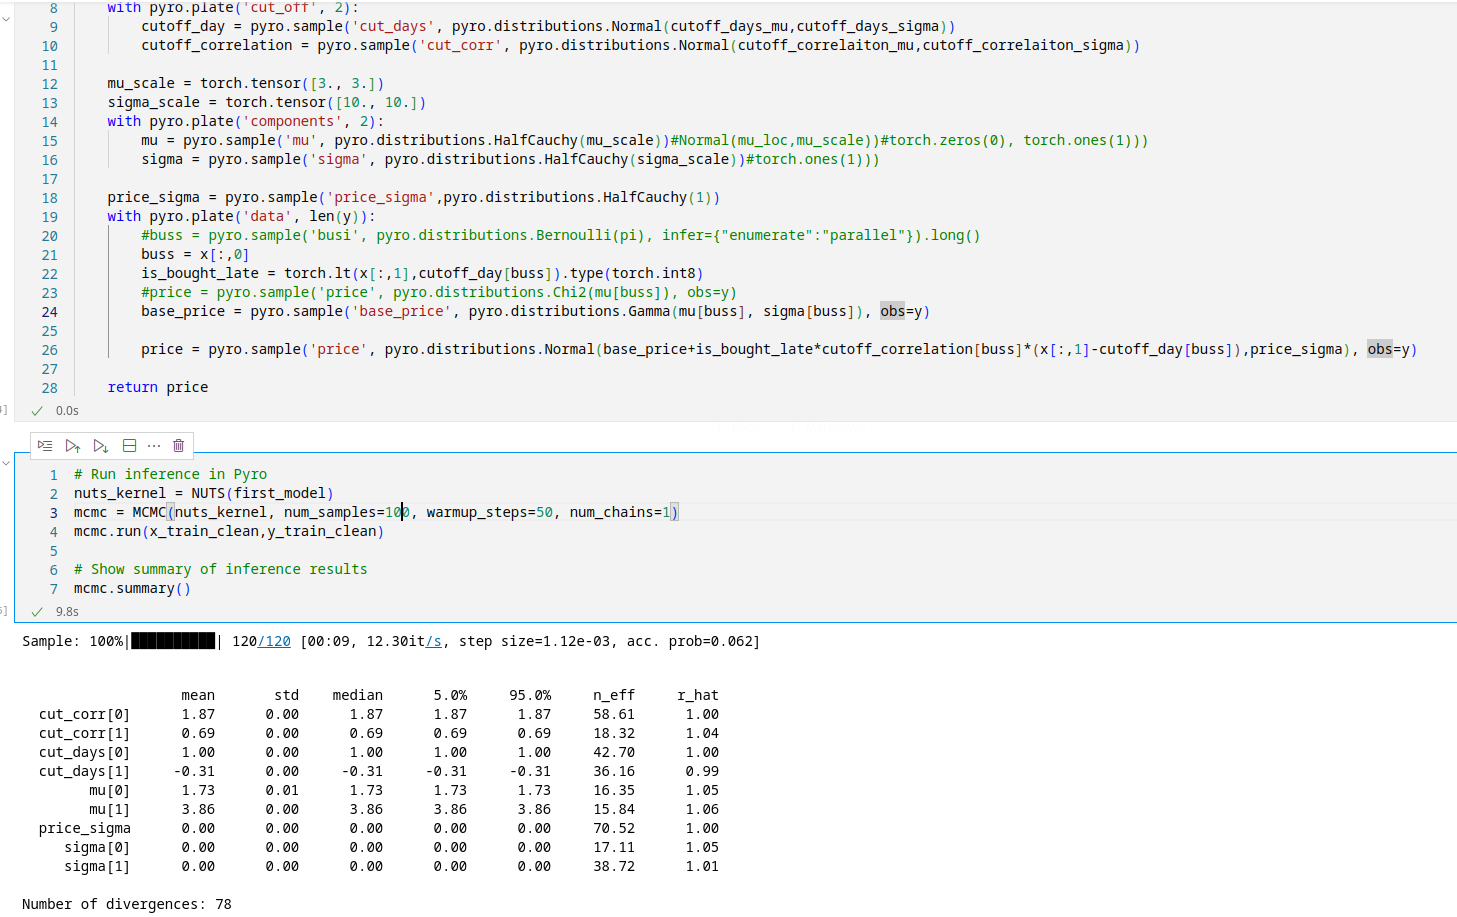
## second
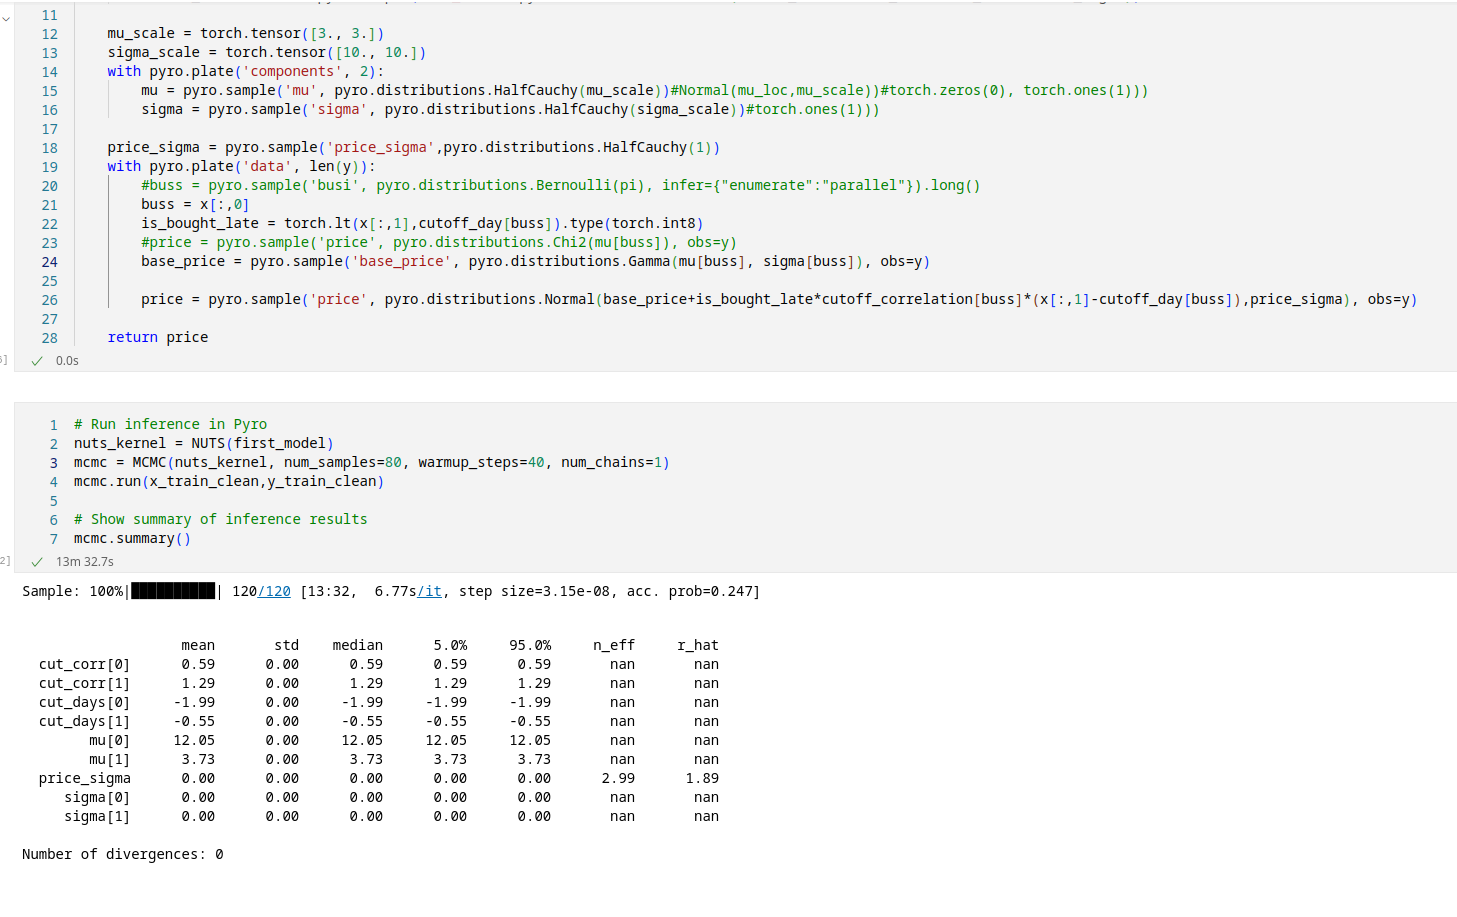
## testing of the second one

# adding a more specific features on top of class

In [ ]:
business_df.columns

In [ ]:
business_df
just_b_df = business_df[business_df['Economy'] == 0]
just_e_df = business_df[business_df['Economy'] == 1]

In [ ]:
# have a function that can see if there is some correlation in the attribute and the price, for business and economy class
def show_if_att_correlated(column):
    ax1 = plt.subplot(121)
    ax1.hist2d(just_b_df[column], just_b_df['price'], bins=10)
    ax2 = plt.subplot(122)#, sharey=ax1)
    ax2.hist2d(just_e_df[column], just_e_df['price'], bins=10)
    plt.show()

In [ ]:
# check distribution of the price for each airline separately
for airline in ['airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']:
    just_e_df[just_e_df[airline]>0].hist('price', bins=20)

In [ ]:
np.argmax(just_e_df[['airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']].values, axis=1)

In [ ]:
show_if_att_correlated('days_left')

In [ ]:
show_if_att_correlated('duration')

In [ ]:
show_if_att_correlated('destination_size')

In [ ]:
show_if_att_correlated('source_size')

In [ ]:
def show_hist_2d(columnx,columny, ylim=None , xlim=None ,bins=10, title=None):
    plt.hist2d(business_df[columnx], business_df[columny], bins=bins)
    axes = plt.gca()
    axes.set_ylim(ylim)
    axes.set_xlim(xlim)
    plt.title(title)
    plt.show()

In [ ]:
show_hist_2d('duration','price', title='Price and duration 2d histogram',ylim=[0,80000], xlim=[1,30],bins=50)

In [ ]:
show_hist_2d('days_left', 'price', title='days left and price 2d histogram' ,bins=30, ylim=[0,80000])

# running pca to get idea as of whst is important

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)

In [ ]:
X = business_df.drop('price', inplace=False, axis=1)


In [ ]:
X_s = StandardScaler().fit_transform(X)
pcas = PCA(n_components=2)
ress = pcas.fit_transform(X_s)
print(pcas.explained_variance_ratio_)
print('sum:', np.sum(pcas.explained_variance_ratio_))

In [ ]:
plt.matshow(pcas.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X.columns)),
           X.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.show()

In [ ]:
# lets see the correlation matrix
corr_m = business_df.corr()

mask = np.triu(corr_m)
plt.figure(figsize=(17,17))
sns.heatmap(corr_m, annot=True, mask=mask)
plt.show()
